# Theory
## Background: **M**arkov **C**hain **M**onte **C**arlo (MCMC)

Oftentimes probability distributions are difficult to analytically express or normalize. However, it is still possible to sample over the entire distribution given the ratio of the probabilities between two points. Starting at some initial point $\vec{q_i}$, we can randomly draw a new value $\vec{q_{try}}$ and define this ratio as the probability to accept $\vec{q_{try}}$ as the new starting point:
$$P_{\rm accept} = \min\left(1, \frac{P(\vec{q_{\rm try}})}{P(\vec{q_{i}})}\right)$$

The most basic method of implementing this is the Metropolis-Hastings algorithm. To get $\vec{q_{try}}$, the MH algorithm simply draws from a gaussian with a mean of $\vec{q_i}$. This algorithm, though simple, works very well on problems where $\vec{q}$ has a small number of dimensions. However, as $\vec{q}$ grows in size, the chance that $P(\vec{q_{\rm try}}) > P(\vec{q_{i}})$ gets very small. As a result, $P_{\rm accept}$ drops to nearly zero, and the algorithm takes a very long time to converge. To fix this, we must modify our method of drawing $\vec{q_{try}}$ to keep $P_{\rm accept}$ as large as possible.

# 1. Documentations and useful knowledges

*   **Demo/Animation:** The Markov-chain Monte Carlo Interactive Gallery
 (https://chi-feng.github.io/mcmc-demo/app.html?algorithm=HamiltonianMC&target=banana)
*   **Paper:** ''*Data Analysis Recipes: Using Markov Chain Monte Carlo*'' (https://arxiv.org/pdf/1710.06068)
*   **JAX Documentation:** https://docs.jax.dev/en/latest/index.html
*   **Conceptual Introduction to HMC:** https://arxiv.org/pdf/1701.02434
*   **MCMC using Hamiltonian Dynamics:** https://arxiv.org/pdf/1206.1901


## **H**amiltonian **M**onte **C**arlo (HMC)

Let's start with the crazy first step of doubling the number of parameters we have, and sampling from $P(\vec{q}, \vec{p})=P(\vec{q})P(\vec{p})$. The key idea here is that we can choose $\vec{p}$ to be independent of $\vec{q}$, and we can choose what $P(\vec{p})$ looks like. In most cases, we will choose a gaussian.
$$P(q,p) = P(q)e^{-\frac{p^2}{2m}}$$

We can suggestively rewrite this as follows so that we can think in terms of a Hamiltonian $H$

$$P(q,p) = e^{-\left(\frac{p^2}{2m} - \ln(P(q))\right)}$$

$$H(q,p) = \frac{p^2}{2m} + U(q), \space U(q) = -\ln{P(q)}$$

Now, if we find a way to get a new set of variables $p_{try}$ and $q_{try}$ that have the same energy, we will be guaranteed to accept the new set of variables. Luckily, Classical Mechanics comes to the rescue with Hamilton's Equations:

$$\frac{dq}{dt}=\frac{\partial H}{\partial p}, \space \frac{dp}{dt}=-\frac{\partial H}{\partial q}$$

Now, how will our algorithm actually work? If we begin with initial position $q_i$, then $p_i$ will be selected with a Gaussian random draw with a mean of zero and variance equal to some mass $m$. $q_{\rm try}$ and $p_{\rm try}$ can then be obtained by numerically integrating Hamilton's equations. If we do this perfectly, we are guaranteed to accept our step and can store $q_{\rm try}$.

$$\\\\ \\\\$$

In [ ]:
!pip install --no-cache-dir git+https://github.com/ua-2025q3-astr501-513/p1-the-physics-team.git

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import grad, random, vmap
from tqdm.notebook import tqdm
import hmc

from getdist import MCSamples, plots
%matplotlib inline
import matplotlib.pyplot as plt

names = [r'$x$',r'$y$']

### Define the Kinetic and Potential Energies

$$ T(p) = \frac{p^2}{2m}, \quad V(q) = -\ln P(q) $$

In [ ]:
def Potential(q, L):
    """
    Compute the potential energy U(q) = -ln(L(q)) in JAX function form.
    Parameters
    ----------
    q : array-like
        Position, in parameter space.
    L : callable
        Function of a probability distribution P(q) related to Hamiltonian H(q, p).
        This is what we want to sample from. We hoped to use "P" for parameter
        name, but this will cause ambiguity with the Potential name.
    Returns
    -------
    float
        Negative log-potential energy at position q.
    """
    return -jnp.log(L(q))

def Kinetic(p, minv):
    """
    Compute the kinetic energy K(p) = 0.5 * (p^T M^{-1} p) in JAX function form.

    Parameters
    ----------
    p : array-like
        Momentum vector.
    mass : array-like
        Mass matrix. We already considered higher-dimensional momentum 
		vectors. So that the mass is also a matrix, where only the diagonal 
		entries are non-zero.

    Returns
    -------
    float
        Kinetic energy corresponding to momentum p.
    """
    return 0.5 * p @ minv @ p   # = 0.5 * (p^T M^{-1} p)

### Leapfrog Integration

It should be noted that integrators do not perfectly conserve energy, so a symplectic integrator must be carefully selected to prevent any systematic drift in energy. The acceptance probability then becomes:

$$P_{\rm accept} = \min(1, e^{-\Delta H})$$

where $\Delta H$ is simply the difference in energy between $q_{\rm try}$ and the previous point. We specifically choose to implement the Leapfrog algorithm.

For a timestep $\Delta t$, begin by evaluating the momentum $p(t)$ at the next half-step $t+\frac{\Delta t}{2}$:
$$p_{n+1/2} = p_{n-1/2} - \frac{\Delta t}{2} \frac{\partial U}{\partial q}|_{q_n}$$

Then utilize this to evaluate position at integer timesteps:

$$q_{n+1} = q_n + \frac{1}{m}p_{n+1/2} \Delta t$$

The process then repeats for the desired number of steps, with $p$ updated each half-step and $q$ updated each integer step.

<center>
  <img src="https://raw.githubusercontent.com/ua-2025q3-astr501-513/p1-the-physics-team/main/doc/HMC-leapfrog-cropped.gif" width="500">
</center>

In [ ]:
def Leapfrog(q0, p0, dt, Nsteps, L, Massinv):
    """
    A leapfrog integrator solving for Hamiltonian (H) in the kick-drift-kick scheme.
	This was introduced in Lecture 9 (Mon, Sep 29, 2025):
	https://ua-2025q3-astr501-513.github.io/notes-9/#leapfrog-verlet-integrator

    Parameters
    ----------
    q0 : array-like
        Initial position.
    p0 : array-like
        Initial momentum.
    dt : float
        Time size for every step.
    Nsteps : int
        Number of leapfrog total integration steps.
    L : callable
		Function of a probability distribution P(q) related to Hamiltonian H(q, p).
    Mass : array-like
        Mass matrix.

    Returns
    -------
    (array, array)
        (Position, momentum) tuple (q, p) giving the new position and momentum after integration.
    """
    q = q0
    dUdq = grad(Potential, argnums=0)
	
    # Half-step momentum update
    p = p0 - 0.5 * dt * dUdq(q, L) # Half-step
    
    # Full steps
    for _ in range(Nsteps - 1):
        q = q + dt * Massinv @ p      # Full-step
        p = p - dt * dUdq(q, L)    # Full-step 
    
    # Final position and half momentum update
    q = q + dt * Massinv @ p          # Final full-step
    p = p - 0.5 * dt * dUdq(q, L)  # Final half-step
    
    return q, p

### Sampler
At the start of each iteration, a random momentum vector is drawn from a Gaussian distribution $p \sim \mathcal{N}(0, M)$, where M is the mass matrix. The current state ($q_i$, $p_i$) is then evolved through a series of Leapfrog steps to produce a proposal ($q_{\text{try}}$, $p_{\text{try}}$). The potential energy $U(q) = -\ln P(q)$ and kinetic energy $T(p) = \frac{1}{2} p^T M^{-1} p$ are evaluated before and after the integration to compute the total Hamiltonian H = U + K.

Because numerical integration does not perfectly conserve energy, the acceptance criterion is used to correct for small integration errors. The acceptance probability is given by

$P_{\text{accept}} = \min(1, e^{-\Delta H})$,
where $\Delta H = H_{\text{final}} - H_{\text{initial}}$.

If the proposed state is accepted, the sampler moves to $q_{\text{try}}$; otherwise, it remains at $q_i$. This allows HMC to explore high-dimensional probability distributions efficiently, avoiding the slow random-walk behavior typical of traditional MCMC methods.

In [ ]:
def Sampler(q0, dt, Nsteps, L, Mass, Massinv, rng_key):
    """
    HMC sampler using leapfrog integrator.

    Parameters
    ----------
    q0 : array-like
        Initial position.
    dt : float
        Time size for every step.
    Nsteps : int
        Number of leapfrog total integration steps.
    L : callable
        Likelihood function.
    Mass : array-like
        Mass matrix.

    Returns
    -------
    array-like
        New sample position after Metropolis acceptance test.
    """
    # Draw a random momentum vector from the Normal distribution: p ~ N(0, Mass)
    key1, key2 = random.split(rng_key)
    p0 = random.multivariate_normal(key1, jnp.zeros_like(q0), Mass)

	# Compute new (q, p) after given N steps from the leapfrog integration
    q, p = Leapfrog(q0, p0, dt, Nsteps, L, Massinv)

    # Compute initial and final energies
	# Reason: In fact, in numerical calculation, we cannot compute the true path of (q, p)
	#         with the constant Hamiltonian/energy. Check what the difference is below. 
    Uinit  = Potential(q0, L)
    Ufinal = Potential(q, L)
    Kinit  = Kinetic(p0, Massinv)
    Kfinal = Kinetic(p, Massinv)

    # Metropolis acceptance criterion
    # Reason: If ideally, our computed (q_new, p_new) has the same energy, we are
    #         very happy to accept this (q_new, p_new). Otherwise (also in most cases), 
    #         we still accept it but with a likelihood of ~ min(1, e^{-ΔH}).
    accept_prob = jnp.exp(Uinit - Ufinal + Kinit - Kfinal)
    u = random.uniform(key2)

    return jnp.where(u < accept_prob, q, q0)

### HMC

In [ ]:
def Hmc(q0, Nsamples, dt, Nsteps, L, Mass, burnin=0, rng_key=None):
    """
    Main Hamiltonian Monte Carlo (HMC) sampling.

    Parameters
    ----------
    q0 : array-like
        Initial position (a parameter vector).
    Nsamples : int
        Number of samples.
    dt : float
        Time size for every leapfrog integration step.
    Nsteps : int
        Number of leapfrog steps per sample.
    L : callable
        Likelihood distribution function of position/parameter.
    Mass : array-like
        Mass matrix.
    burnin : int, optional
        Number of initial samples to discard. Default is 0.
    
    rng_key: array-like, optional
        PRNG key (an array of seeds) to be used in random sampling. Defaults to a PRNG key with seed = 0.

    Returns
    -------
    np.ndarray
        Array of accepted samples after burn-in.
    """

    if rng_key is None:
        rng_key = random.PRNGKey(0)

    # Set first q_current to be initial positions q0
    q_current = q0
    samples = []

    # Compute inverse of mass matrix
    minv = jnp.linalg.inv(Mass) # = M^{-1}

    # Run the sampler
    for _ in tqdm(range(Nsamples + burnin)):
        # Generate new key
        rng_key, subkey = random.split(rng_key)

        # Update q_current based upon the previous q_current, using the method outlined in Sampler
        q_current = Sampler(q_current, dt, Nsteps, L, Mass, minv, subkey)
        samples.append(q_current)
    
    # Remove burn-in samples
    return jnp.array(samples[burnin:])

### Premium HMC

In [ ]:
def Hmc_Vectorized(q0_array, Nsamples, dt, Nsteps, L, Mass, burnin=0, rng_key=None):
    """
    Vectorized Hamiltonian Monte Carlo (HMC) sampling.

    TODO: Add comments later

    Parameters
    ----------
    q0 : array-like
        Initial position (a parameter vector).
    Nsamples : int
        Number of samples.
    dt : float
        Time size for every leapfrog integration step.
    Nsteps : int
        Number of leapfrog steps per sample.
    L : callable
        Likelihood distribution function of position/parameter.
    Mass : array-like
        Mass matrix.
    burnin : int, optional
        Number of initial samples to discard. Default is 0.
    
    rng_key: array-like, optional
        PRNG key (an array of seeds) to be used in random sampling. Defaults to a PRNG key with seed = 0.

    Returns
    -------
    np.ndarray
        Array of accepted samples after burn-in.
    """

    if rng_key is None:
        rng_key = random.PRNGKey(0)

    Nchains = q0_array.shape[0]
    minv = jnp.linalg.inv(Mass) # = M^{-1}

    # Vectorize the Sampler function across chains
    sampler_vectorized = vmap(
        lambda q, key: Sampler(q, dt, Nsteps, L, Mass, minv, key),
        in_axes=(0, 0)
    )

    q_current = q0_array
    samples = []

    # Progress bar tracks total samples across all chains
    pbar = tqdm(total=(Nsamples//Nchains) * Nchains, desc="HMC sampling")

    for i in range(Nsamples//Nchains + burnin):
        # Generate one key per chain
        rng_key, *subkeys = random.split(rng_key, Nchains + 1)
        subkeys = jnp.array(subkeys)

        # Update all chains in parallel
        q_current = sampler_vectorized(q_current, subkeys)
        samples.append(q_current)

        if i >= burnin:
            pbar.update(Nchains)
    
    pbar.close()

    # Remove burn-in samples and convert to array
    samples = jnp.array(samples[burnin:])

    # Reshape to (Nsamples, Ndim)
    return samples.reshape(-1, samples.shape[-1])

## Testing with Distributions

### - Gaussian Distribution

In [8]:
def Gaussian(q):
    #cov = jnp.array([[1, 0.5], [0.5, 1]])
    covinv = jnp.array([[4./3., -2./3.],[-2./3., 4./3.]])
    return jnp.exp(-0.5 * q @ covinv @ q)

HMC sampling:   0%|          | 0/4992 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in


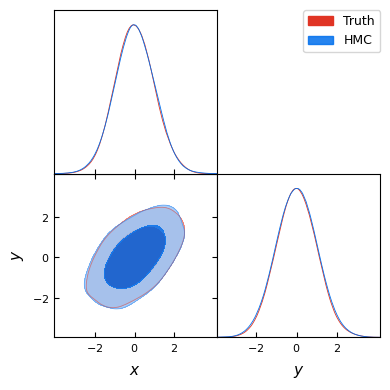

In [9]:
key = random.PRNGKey(42)
q0_array = random.normal(key, (16, 2))  # 16 chains starting from different points

samples = Hmc_Vectorized(q0_array, Nsamples=5000, dt=0.1, Nsteps=10, 
                         L=Gaussian, Mass=jnp.eye(2), burnin=10, rng_key=key)
hmc_samps = MCSamples(samples=samples, names=names,label="HMC")

# ==== Comparison with truth
true_samples = np.random.multivariate_normal(np.zeros(2),jnp.array([[1, 0.5], [0.5, 1]]),5000)
true_samps = MCSamples(samples=true_samples, names=names,label="Truth")
# ====
g = plots.get_subplot_plotter()
g.triangle_plot([true_samps, hmc_samps], filled=True, smooth_scale_1D=1., smooth_scale_2D=1.)

### - Gaussian 1D Distribution
$$p(x; \mu, \sigma) = \exp\!\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)$$

In [10]:
# Ex. Gaussian 1D
def Gaussian1D(q, mu=0.0, sigma=1.0):
    """
    A 1D Gaussian (normal) probability distribution.
    
    Parameters
    ----------
    q : array-like, shape (1,) or scalar
        Position in 1D space.
    mu : float
        Mean of the distribution.
    sigma : float
        Standard deviation of the distribution.
    
    Returns
    -------
    float
        Unnormalized probability density at position q.
    """
    # Extract scalar if q is an array
    x = q[0] if hasattr(q, '__len__') else q
    
    # Gaussian probability density (unnormalized is fine for HMC)
    prob = jnp.exp(-0.5 * ((x - mu) / sigma)**2)
    
    return prob

HMC sampling:   0%|          | 0/304 [00:00<?, ?it/s]

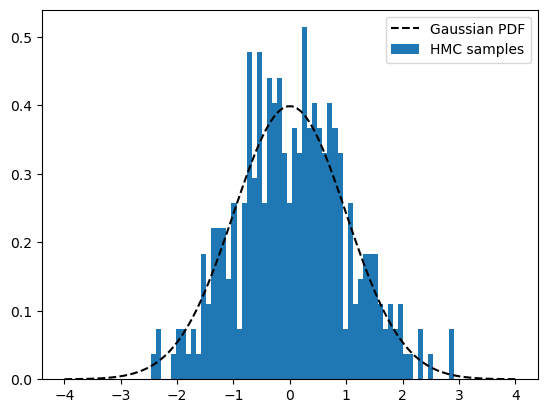

In [ ]:
key = random.PRNGKey(42)
q0_array = random.normal(key, (16, 1))
samples = Hmc_Vectorized(q0_array, 5000, 0.5, 2, Gaussian1D, jnp.eye(1),20)
# ==== Plot expected vs. samps
x_vals = np.linspace(-4, 4, 100)
y_vals = np.array([Gaussian1D(jnp.array([x]), mu=0.0, sigma=1.0) for x in x_vals])/np.sqrt(2*np.pi)

plt.plot(x_vals, y_vals, label='Gaussian PDF',color='black',linestyle='dashed')
plt.hist(samples.ravel(), density=True, label='HMC samples',bins=60)
plt.legend()
plt.show()

### - Donut Distribution 

$$P(x,y) = exp\left(-0.5 \frac{|\sqrt{(x^2+y^2)}-R|}{r}\right)$$

This one might take a bit longer to run

In [12]:
def Donut(q, R=2.0, r=0.5):
    """
    A donut (torus) shaped 2D probability distribution.
    
    Parameters
    ----------
    q : array-like, shape (2,)
        Position [x, y] in 2D space.
    R : float
        Radius from origin to center of donut tube (major radius).
    r : float
        Radius of the donut tube itself (minor radius).
    
    Returns
    -------
    float
        Unnormalized probability density at position q.
    """
    x, y = q[0], q[1]
    
    # Distance from origin
    distance_from_origin = jnp.sqrt(x**2 + y**2)
    
    # Distance from the donut's center ring
    distance_from_ring = jnp.abs(distance_from_origin - R)
    
    # Gaussian falloff from the ring
    # Higher density near the ring (distance_from_ring ≈ 0)
    # Lower density away from the ring
    sigma = r
    prob = jnp.exp(-0.5 * (distance_from_ring / sigma)**2)
    
    return prob

HMC sampling:   0%|          | 0/4992 [00:00<?, ?it/s]

Removed no burn in


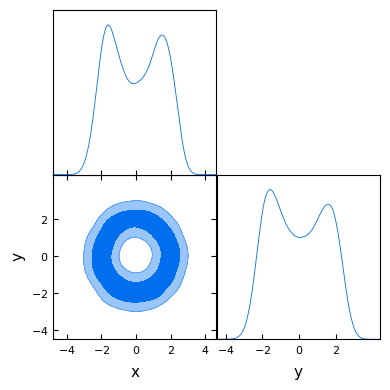

In [13]:
# Ex. Donut
key = random.PRNGKey(42)
q0_array = random.normal(key, (16, 2))  # 16 independent chains

mass = jnp.eye(2)
names = ['x', 'y']

# === Run Vectorized HMC ===
samples = Hmc_Vectorized(q0_array, Nsamples=5000, dt=0.1, Nsteps=20, L=Donut, Mass=mass, burnin=50, rng_key=key)
hmc_samps = MCSamples(samples=samples, names=names, label="HMC (Donut)")

# === Plot ===
g = plots.get_subplot_plotter()
g.triangle_plot([hmc_samps], filled=True, smooth_scale_1D=1.0, smooth_scale_2D=1.0)

## Other distributions we have tested

#### Banana Distribution: $P(x,y) = exp\left(-\frac{(1-x)^2+100(y-x^2)^2}{200}\right)$ 


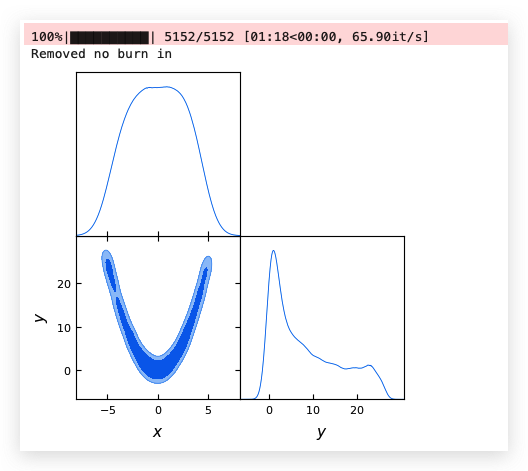

#### Gamma Distribution: $p(x; k, \theta) = \begin{cases} \dfrac{1}{\Gamma(k)\,\theta^k}\, x^{k-1} e^{-x / \theta}, & x > 0, \\ 0, & x \le 0, \end{cases}$


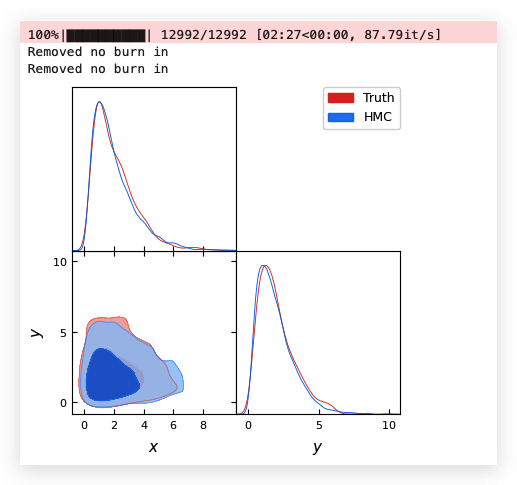


#### Log-Normal Distribution: $\rho_{\mathrm{LN}}(x \mid \mu, \sigma^2, \lambda) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot \frac{1}{x + \lambda} \exp\left( -\frac{1}{2\sigma^2} \left[ \ln(x + \lambda) - \mu \right]^2 \right)$

### Hands-on: Some example distributions you can try on your own

- *Poisson Distribution*: $p(x; \lambda) = \frac{\lambda^x e^{-\lambda}}{x!} $

- *Exponential Distribution*: $p(x; \lambda) = \lambda e^{-\lambda x}$

- *Rayleigh Distribution*: $p(x; \sigma) = \frac{x}{\sigma^2} e^{-x^2 / (2\sigma^2)}$

In [14]:
# HANDSON: try your choice of distribution



